<a href="https://colab.research.google.com/github/BogdanZacheja/Car_logo_detector/blob/master/project_acc80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cars brands detektor
## Objectives of the project:
<br>Choose 20 most popular car brand in europe in 2018
based on this [ranking](https://www.best-selling-cars.com/europe/2018-q3-europe-best-selling-car-manufacturers-and-brands/).
<br>Scrape from google graphics, 1000 image for each brand.
<br>Manualy clean a data.
<br>Make neutronal network for recognize brand using logo photo. 
<br>Compute model using google cloud GPU
<br>Evaluate ans test model

 



In [0]:
#conect notebook to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import gridspec

import numpy as np
from scipy.misc import imresize
import scipy
import pandas as pd
import random

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import adam, RMSprop, SGD

import warnings
warnings.filterwarnings("ignore")

In [0]:
# create list of brands to download
brands = ['VOLKSWAGEN',  'RENAULT', 'FORD', 'PEUGEOT', 'OPEL', 'MERCEDES', 
          'BMW', 'AUDI', 'FIAT', 'SKODA', 'TOYOTA', 'CITROEN', 'HYUNDAI', 
          'NISSAN', 'DACIA', 'KIA', 'SEAT', 'VOLVO', 'MINI', 'JEEP']

# create list features 
list_feature = ['logo', 'logo jpg', 'logo png', 'logo gif', 'logo wector', 
                'logo image', 'logo hd','logo wallpaper', 'logo emblem', 
                'brand logo', 'grill']

# Modify brands to lowercase 
list_brands = []

for brand in brands:
  brand = brand.lower()
  list_brands.append(brand)
  
  
#Create a search words, by appeding to each brand all features 
serch_word = []

for brand in list_brands:
  for feture in list_feature:
    serch_word.append(brand + ' '+ feture)
    
print(serch_word[:5])    

['volkswagen logo', 'volkswagen logo jpg', 'volkswagen logo png', 'volkswagen logo gif', 'volkswagen logo wector']


## Data preparation
<br>Google image scraper for each search word make separate directory.
<br>So I make function for make directory for brands and move there proper images.
<br>By the way I changed file format to jpg, skiped invalid files,
<br> and resized images to 640X640 for save RAM memory.

In [0]:
""" Make directories for brands and move there resized images,
    without invalid files
"""

images_path = '/content/drive/My Drive/logo/'
save_path = '/content/drive/My Drive/logo_folders/'
extension = ('.jpg', '.jpeg', '.png', '.gif')
image_size = (160,160)

for brand in list_brands:
  search_path = images_path + '*' + brand + '*'
  save_path_brand = save_path + brand
  print(search_path)
  glob_filenames = glob.glob(search_path)
  output_dir = save_path + brand
  os.mkdir(output_dir)
  i = 0
  for file_path in glob_filenames:
    print(file_path)
    print('###############################################')
    for root, dirs, files in os.walk(file_path):  
      for file in files:
        if file.endswith(extension):
          try:
            print(file_path + '/' + file)
            image_path = file_path + '/' + file
            save_path_brand = save_path + brand + '/' + brand + str(i) + '.jpg'
            img = Image.open(image_path)
            new_img = img.convert('RGB').resize(image_size).save(save_path_brand)
            print(save_path_brand)
            i += 1
            gc.collect()
          except OSError:
            pass
          except FileNotFoundError:
              pass

In [0]:
# Make varibles with path to data

train_path = "/content/drive/My Drive/logo_folders_sorted2/train/"
validation_path = "/content/drive/My Drive/logo_folders_sorted2/validation/"

Data cleaning

<br>I manualy delete wrong images, I leave images where was olny one proper logo, 
<br>beacause few logo in one image significantly decreased model precision. 
<br>Finally I have deleted 60-80% images in each brand

In [0]:
#Split walidation images to separate folders

Validation_size = 50

for path, dirs, files in os.walk(train_path): 
  for directory in dirs:
    brand_path = train_path + directory + '/'
    save_path = validation_path + directory + '/'
    print (save_path)
    os.mkdir(save_path)
    for  path, dirs, files in os.walk(brand_path):
      random_files = random.sample(files, Validation_size)
      for file in random_files:
        file_path = brand_path + file
        #print (file_path)
        shutil.move(file_path, save_path)

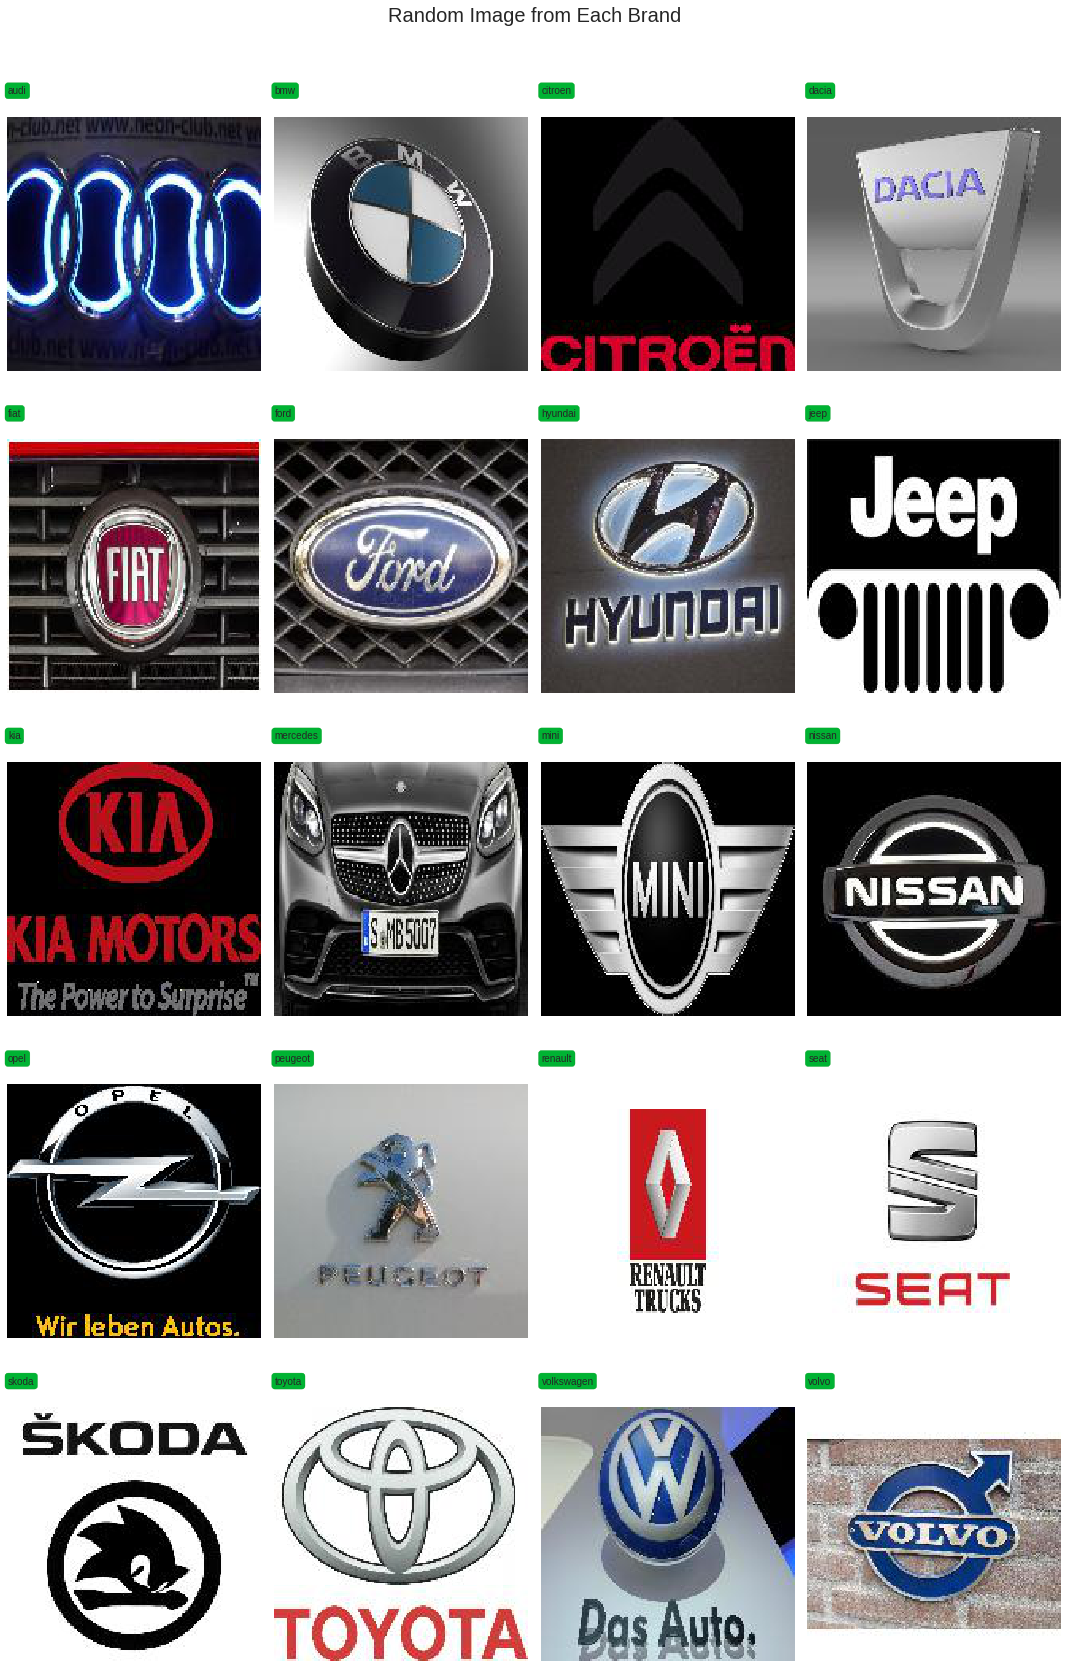

In [0]:
# show random image from each brand

root_dir = train_path
rows = 5
cols = 4
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Brand', fontsize=20)
sorted_dirs = sorted(os.listdir(root_dir))

for i in range(rows):
    for j in range(cols):
        try:
            brand_dir = sorted_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, brand_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, brand_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, brand_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
        
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [0]:
# Assigned brands to classes and classes to brands

class_to_ix = {}
ix_to_class = {}

classes = list_brands
class_to_ix = dict(zip(classes, range(len(classes))))
ix_to_class = dict(zip(range(len(classes)), classes))
class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [0]:
def load_images(root):
  """ Assigned each image to a class
      and make arrays from images
  """
  all_imgs = []
  all_classes = []
  for i, subdir in enumerate(listdir(root)):
    imgs = listdir(join(root, subdir))
    class_ix = class_to_ix[subdir]
    print(i, class_ix, subdir)
    for img_name in imgs:
      img_arr = scipy.misc.imread(join(root, subdir, img_name))
      all_imgs.append(img_arr)
      all_classes.append(class_ix)
  return np.array(all_imgs), np.array(all_classes) 


In [0]:
X_train, y_train = load_images(train_path)
X_val, y_val = load_images(validation_path)


0 5 mercedes
1 2 ford
2 15 kia
3 11 citroen
4 12 hyundai
5 14 dacia
6 8 fiat
7 6 bmw
8 19 jeep
9 7 audi
10 18 mini
11 16 seat
12 1 renault
13 13 nissan
14 9 skoda
15 0 volkswagen
16 3 peugeot
17 10 toyota
18 17 volvo
19 4 opel
0 5 mercedes
1 2 ford
2 15 kia
3 11 citroen
4 12 hyundai
5 14 dacia
6 8 fiat
7 6 bmw
8 19 jeep
9 7 audi
10 18 mini
11 16 seat
12 1 renault
13 13 nissan
14 9 skoda
15 0 volkswagen
16 3 peugeot
17 10 toyota
18 17 volvo
19 4 opel


In [0]:
print('Shapes of train and validation data')
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)

Shapes of train and validation data
X_train shape (6135, 160, 160, 3)
y_train shape (6135,)
X_val shape (1000, 160, 160, 3)
y_val shape (1000,)


In [0]:
def show_random_images_of_class(n_class=0):
    """ Show few images from chosee class"""
    print(n_class)
    nrows = 4
    ncols = 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 8)
    imgs = np.random.choice((y_train == n_class).nonzero()[0], nrows * ncols)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_train[imgs[i]])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()

2


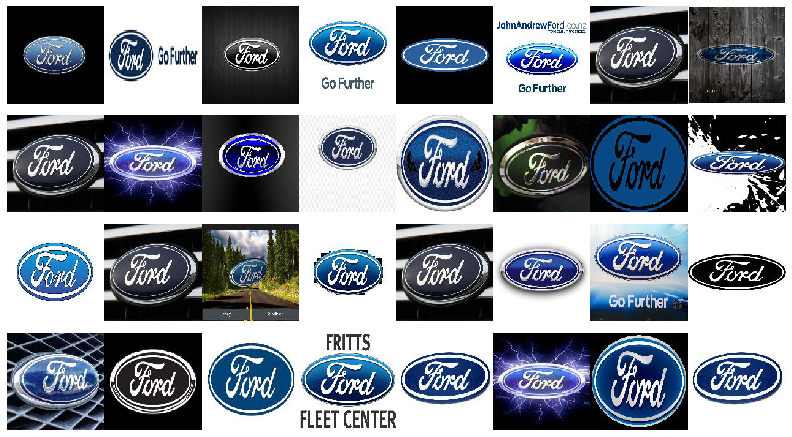

In [0]:
show_random_images_of_class(2)

## Make model 
<br>I deside to use prepared netronal network 'MobilNet' trained on ImageNet dataset
<br>I olny add 3 denese layers onthe top of model. 

In [0]:
# change data to categorical
n_classes = len(list_brands)
y_train_cat =to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)

In [0]:
# Make a generator for scaling, rotating, filiping images 
train_generator = ImageDataGenerator(rescale=1/255, 
                                     rotation_range=90, 
                                     zoom_range=0.2, 
                                     horizontal_flip=True,
                                     vertical_flip = True)
validation_generator =ImageDataGenerator(rescale=1/255)


In [0]:
train_flow = train_generator.flow(X_train, y=y_train_cat,
                                  batch_size=32, )
                                 

validation_flow = validation_generator.flow(X_val, y=y_val_cat,
                                            batch_size=32, )                                                 

In [0]:
from keras.applications import MobileNet
h,w = 160, 160
base_model=MobileNet(weights='imagenet',
                     include_top=False,
                     input_shape=(h, w, 3))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
__________

In [0]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(50, activation='relu'))
top_model.add(Dense(20, activation='sigmoid'))
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1280050   
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
Total params: 1,281,070
Trainable params: 1,281,070
Non-trainable params: 0
_________________________________________________________________


In [0]:
transfer_model = Sequential()
transfer_model.add(base_model)
transfer_model.add(top_model)


transfer_model.layers[0].trainable = False
early_stopping = EarlyStopping(patience=4, monitor='val_loss')
CNN_file = 'model_myself.h5py' 
take_best_model = ModelCheckpoint(CNN_file, save_best_only=True)
transfer_model.compile(loss="categorical_crossentropy",
              optimizer = 'adam',
              metrics = ['categorical_accuracy'])

transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_160 (Model)   (None, 5, 5, 1024)        3228864   
_________________________________________________________________
sequential_1 (Sequential)    (None, 20)                1281070   
Total params: 4,509,934
Trainable params: 1,281,070
Non-trainable params: 3,228,864
_________________________________________________________________


In [0]:
# fit model to data
nb_validation_samples = y_val.shape[0]
nb_train_samples = y_train.shape[0]
transfer_model.fit_generator(generator=train_flow, 
                    samples_per_epoch=nb_train_samples,
                    validation_data=validation_flow,
                    nb_val_samples=nb_validation_samples,
                    epochs=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<keras_pre..., validation_data=<keras_pre..., epochs=10, steps_per_epoch=292, validation_steps=1000)`
  import sys


Epoch 1/10
292/292 [==============================] - 1870s 6s/step - loss: 2.7287 - categorical_accuracy: 0.1574 - val_loss: 2.4230 - val_categorical_accuracy: 0.2639
Epoch 2/10
292/292 [==============================] - 1864s 6s/step - loss: 2.0706 - categorical_accuracy: 0.3712 - val_loss: 1.9383 - val_categorical_accuracy: 0.4641
Epoch 3/10
292/292 [==============================] - 1850s 6s/step - loss: 1.6777 - categorical_accuracy: 0.4872 - val_loss: 1.4707 - val_categorical_accuracy: 0.5848
Epoch 4/10
292/292 [==============================] - 1846s 6s/step - loss: 1.4882 - categorical_accuracy: 0.5529 - val_loss: 1.3492 - val_categorical_accuracy: 0.6229
Epoch 5/10
292/292 [==============================] - 1847s 6s/step - loss: 1.2872 - categorical_accuracy: 0.6178 - val_loss: 1.1246 - val_categorical_accuracy: 0.6821
Epoch 6/10
292/292 [==============================] - 1849s 6s/step - loss: 1.1596 - categorical_accuracy: 0.6563 - val_loss: 0.9847 - val_categorical_accuracy:

In [0]:
transfer_model.save("/content/drive/My Drive/logo_dataset/model20classes_MobilNet.h5")

In [0]:
transfer_model = load_model("/content/drive/My Drive/logo_dataset/model20classes_MobilNet.h5")

Instructions for updating:
Colocations handled automatically by placer.


## Evaluate model 
<br> Model had precision on the level 80%.
<br>In my opinion it is god score., but shoud be better.

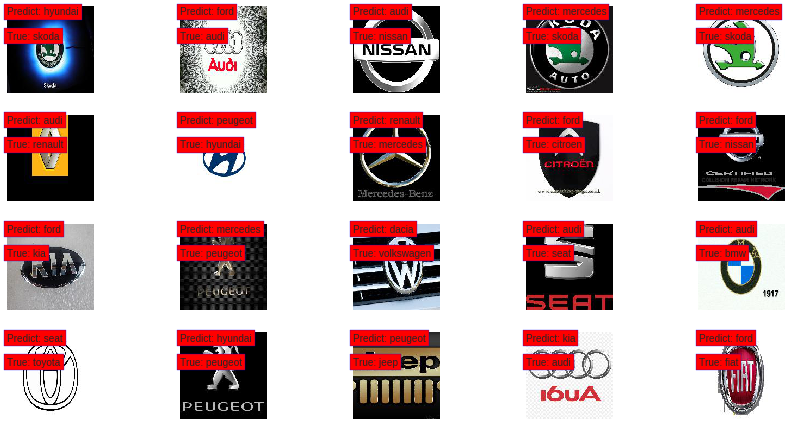

In [0]:
def show_images_and_prediction(page=0):
#Show random images with predicted brand if model predict wrong brand show true brand
    y_pred = transfer_model.predict(X_val)
    preds = np.argmax(y_pred, axis=1)
    random = np.random.randint(0,len(y_val))
    n_class = 20
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    #imgs = np.random.choice((y_all == n_class).nonzero()[0], nrows * ncols)
    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        random = np.random.randint(0,len(y_val))
        im = ax.imshow(X_val[random])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        predicted = ix_to_class[preds[random]]
        match = predicted ==  ix_to_class[y_val[random]]
        ec = 'b'
        fc = 'r'
        if match:
            ec = 'b'
            fc = 'g'
        # predicted label
        ax.text(0, 0, 'Predict: ' + predicted, size=10, rotation=0,
            ha="left", va="top",
             bbox=dict(boxstyle="Square",
                   ec=ec,
                   fc=fc,
                   )
             )
        if not match:
            # true label
            ax.text(0, 45, 'True: ' + ix_to_class[y_val[random]], size=10, rotation=0,
                ha="left", va="top",
                 bbox=dict(boxstyle="Square",
                       ec=ec,
                       fc=fc,
                       )
                 )
    plt.subplots_adjust(left=0, wspace=1, hspace=0)
    plt.show()
    
show_images_and_prediction(2)

In [0]:
from sklearn.metrics import precision_recall_fscore_support as prfs
y_pred_class = transfer_model.predict_classes(X_val)
precision, recall, f1, support = prfs(y_val, y_pred_class, average='weighted')
print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}".format(precision, recall, f1))
precision_, recall_, f1_, support_ = prfs(y_val, y_pred_class, average=None)

Precision: 78.95%
Recall: 74.30%
F1 score: 74.75%


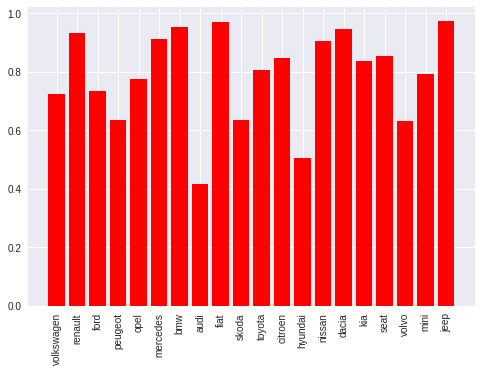

In [0]:
#show precision score for each brand
plt.bar(range(len(classes)), precision_, color='Red')
plt.xticks(range(len(classes)), classes, rotation = 90)
plt.title("precision score")
plt.show()

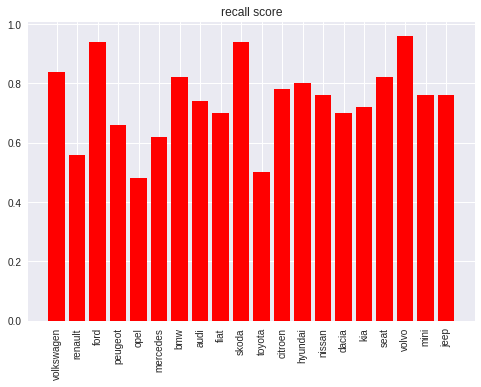

In [0]:
#show recall score for each brand
plt.bar(range(len(classes)), recall_, color='Red')
plt.xticks(range(len(classes)), classes, rotation = 90)
plt.title("recall score")
plt.show()

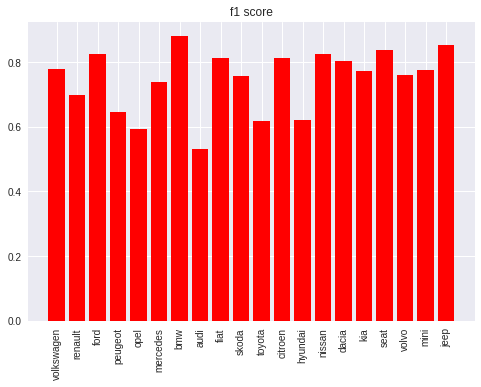

In [0]:
#show recall score for each brand
plt.bar(range(len(classes)), f1_, color='Red')
plt.xticks(range(len(classes)), classes, rotation = 90)
plt.title("f1 score")
plt.show()

In [0]:
def image_and_propability (num_image):
  names = classes
  probs = transfer_model.predict_proba(X_val)[num_image]
  y_pred = transfer_model.predict(X_val)
  preds = np.argmax(y_pred, axis=1)
  predicted = ix_to_class[preds[random]]
  match = predicted ==  ix_to_class[y_val[random]]

  plt.figure(figsize=(20,5))
  gs = gridspec.GridSpec(1, 2, width_ratios=[4, 10])

  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])

  ax1.imshow(X_val[num_image])
  ec = 'b'
  fc = 'r'
  if match:
      ec = 'b'
      fc = 'g'
  ax1.text(0, 0, 'Predict: ' + predicted, size=10, rotation=0,
            ha="left", va="top",
             bbox=dict(boxstyle="Square",
                   ec=ec,
                   fc=fc,
                   )
             )
  if not match:
      # true label
      ax1.text(0, 10, 'True: ' + ix_to_class[y_val[random]], size=10, rotation=0,
          ha="left", va="top",
           bbox=dict(boxstyle="Square",
                 ec=ec,
                 fc=fc,
                 )
           )
  ax2.bar(names, probs)
  plt.title('Propabilities for each brand',)
  plt.figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')
  plt.show()

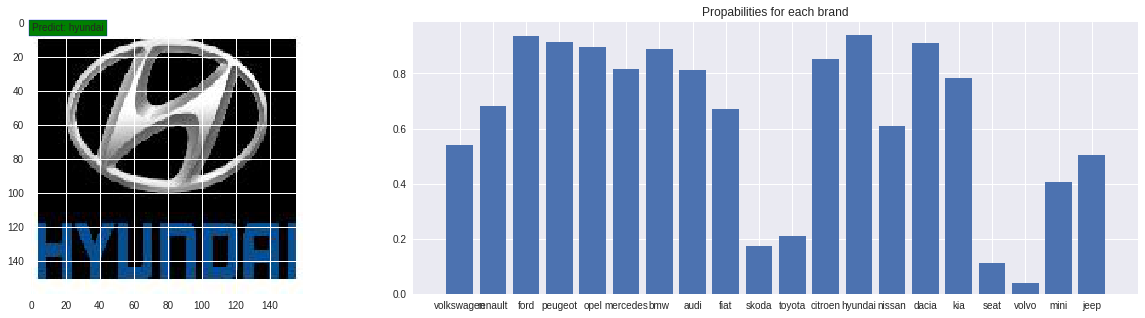

<Figure size 800x960 with 0 Axes>

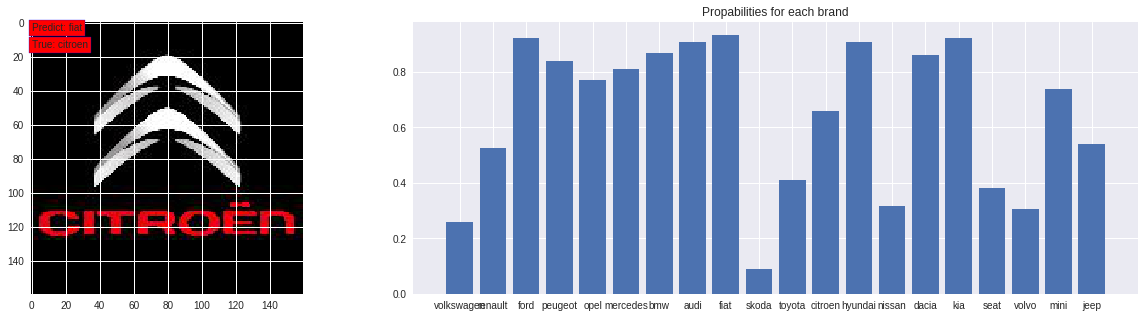

<Figure size 800x960 with 0 Axes>

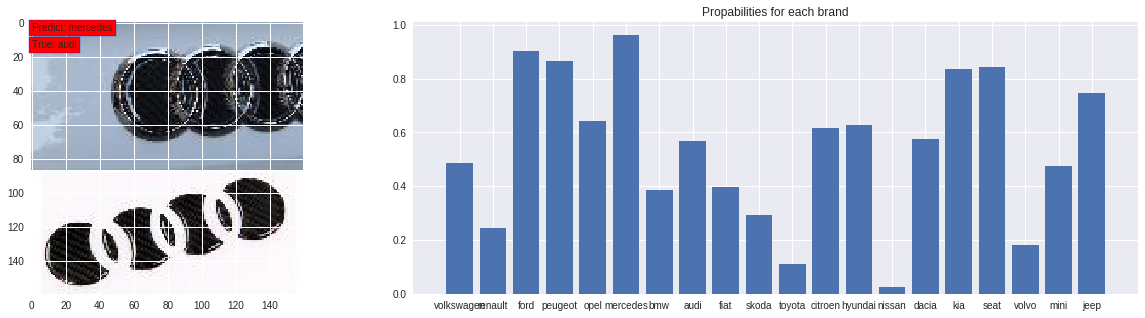

<Figure size 800x960 with 0 Axes>

In [0]:
import numpy as np
for i in range(3):
  random = np.random.randint(0,len(y_val))
  image_and_propability(random)

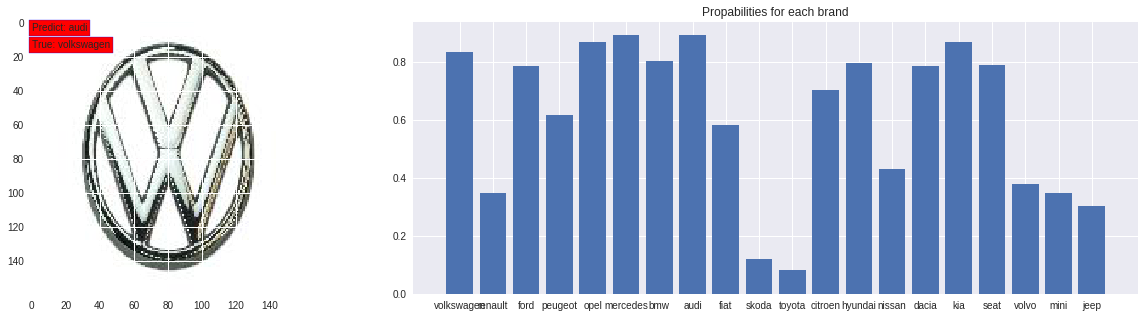

<Figure size 800x960 with 0 Axes>

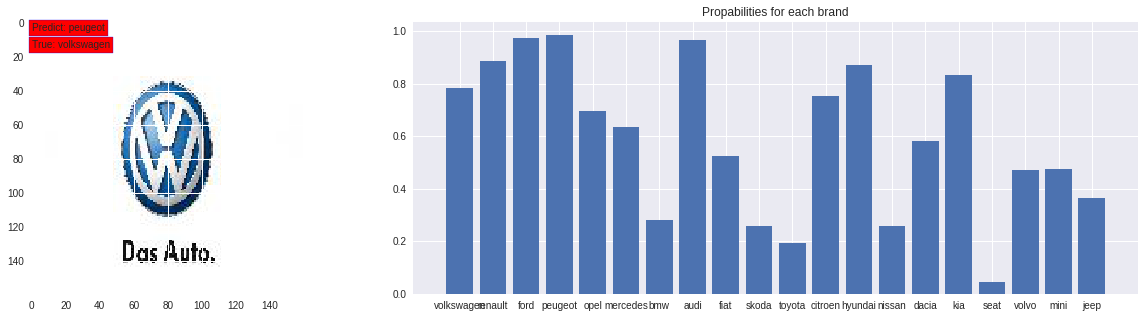

<Figure size 800x960 with 0 Axes>

In [0]:
import numpy as np
for i in range(3):
  random = np.random.randint(0,len(y_val))
  image_and_propability(random)

##Plans for future.

<br>Expand learnig dataset to 1000 good quality image for each brand using YOLO for extract logos from photos 
<br>Expand set brands to about 50. 
<br>Maybe use my data to make dataset on kaggle platform.

In [0]:
#second model make my sefl

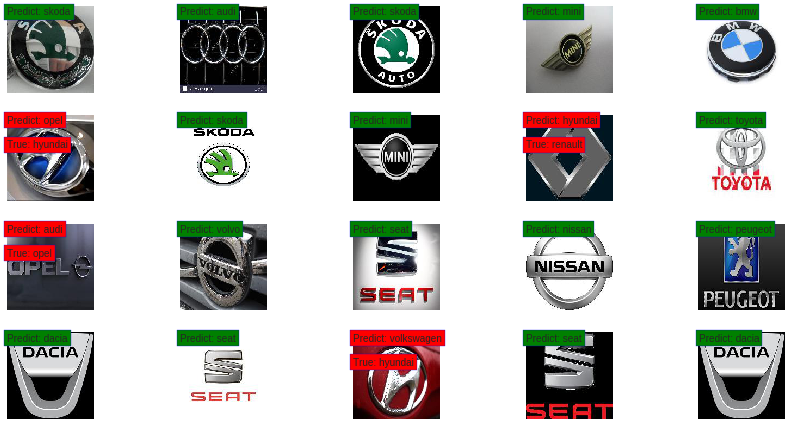

In [0]:
y_pred = model.predict(X_val)
preds = np.argmax(y_pred, axis=1)
n_class = 20


def show_images_and_prediction(page=0):
#Show random images with predicted brand if model predict wrong brand show true brand
    y_pred = model.predict(X_val)
    preds = np.argmax(y_pred, axis=1)
    random = np.random.randint(0,len(y_val))
    n_class = 20
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    #imgs = np.random.choice((y_all == n_class).nonzero()[0], nrows * ncols)
    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        random = np.random.randint(0,len(y_val))
        im = ax.imshow(X_val[random])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        predicted = ix_to_class[preds[random]]
        match = predicted ==  ix_to_class[y_val[random]]
        ec = 'b'
        fc = 'r'
        if match:
            ec = 'b'
            fc = 'g'
        # predicted label
        ax.text(0, 0, 'Predict: ' + predicted, size=10, rotation=0,
            ha="left", va="top",
             bbox=dict(boxstyle="Square",
                   ec=ec,
                   fc=fc,
                   )
             )
        if not match:
            # true label
            ax.text(0, 45, 'True: ' + ix_to_class[y_val[random]], size=10, rotation=0,
                ha="left", va="top",
                 bbox=dict(boxstyle="Square",
                       ec=ec,
                       fc=fc,
                       )
                 )
    plt.subplots_adjust(left=0, wspace=1, hspace=0)
    plt.show()
    
show_images_and_prediction(2)

In [0]:
# prepare a model 
model = Sequential()
model.add(Conv2D(6,(5,5),activation="relu",padding="same",
                 data_format="channels_last",
                 input_shape=(160,160,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3)))               
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3)))                
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3)))                 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(4096, activation='relu', bias_initializer='lecun_normal'))
model.add(Dense(2048, activation='relu', bias_initializer='lecun_normal'))
model.add(Dense(512, activation='relu', bias_initializer='lecun_normal'))


model.add(Dense(len(list_brands), activation='softmax'))


early_stopping = EarlyStopping(patience=4, monitor='val_loss')
CNN_file = 'model_myself.h5py' 
take_best_model = ModelCheckpoint(CNN_file, save_best_only=True)


sgd = SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 160, 160, 6)       456       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 80, 80, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 78, 78, 64)        3520      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 256)       295168    
__________

In [0]:
nb_validation_samples = 1000
nb_train_samples = 9361
model.fit_generator(generator=train_flow, 
                    samples_per_epoch=nb_train_samples,
                    validation_data=validation_flow,
                    nb_val_samples=nb_validation_samples,
                    epochs=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<keras_pre..., validation_data=<keras_pre..., epochs=5, steps_per_epoch=292, validation_steps=1000)`
  import sys


Epoch 1/5
292/292 [==============================] - 1892s 6s/step - loss: 0.7745 - categorical_accuracy: 0.7770 - val_loss: 0.6046 - val_categorical_accuracy: 0.8350
Epoch 2/5
292/292 [==============================] - 1899s 7s/step - loss: 0.7579 - categorical_accuracy: 0.7860 - val_loss: 0.6398 - val_categorical_accuracy: 0.8211
Epoch 3/5
292/292 [==============================] - 1909s 7s/step - loss: 0.7357 - categorical_accuracy: 0.7920 - val_loss: 0.6128 - val_categorical_accuracy: 0.8323
Epoch 4/5
292/292 [==============================] - 1899s 7s/step - loss: 0.7800 - categorical_accuracy: 0.7864 - val_loss: 0.8350 - val_categorical_accuracy: 0.7950
Epoch 5/5
292/292 [==============================] - 1903s 7s/step - loss: 0.7884 - categorical_accuracy: 0.7762 - val_loss: 0.7119 - val_categorical_accuracy: 0.8148


In [0]:
# Save model
model.save("/content/drive/My Drive/logo_dataset/model20classes_v1.h5")

In [0]:
# Load model 
model = load_model("/content/drive/My Drive/logo_dataset/model20classes_v1.h5")

In [0]:
from sklearn.metrics import precision_recall_fscore_support as prfs
y_pred_class = model.predict_classes(X_val)
precision, recall, f1, support = prfs(y_val, y_pred_class, average='weighted')
print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}".format(precision, recall, f1))
precision_, recall_, f1_, support_ = prfs(y_val, y_pred_class, average=None)

Precision: 78.95%
Recall: 74.30%
F1 score: 74.75%


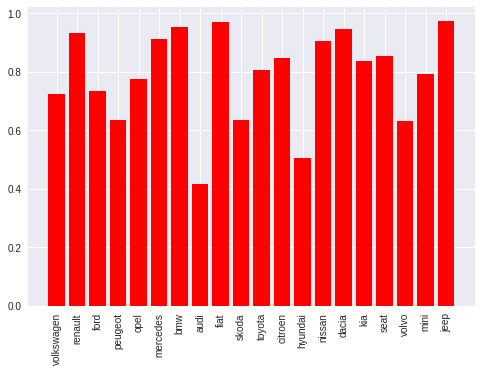

In [0]:
precision_, recall_, f1_, support_ = prfs(y_test, y_pred_class, average=None)


plt.bar(range(20), precision_, color='Red')
plt.xticks(range(20), classes, rotation = 90)
plt.bar(range(20), precision_, color='Red')
plt.xticks(range(20), classes, rotation = 90)
plt.show()